# Example ? $\chi \chi \to b \bar{b}$

In this notebook, we'll show you how to use the code to obtain the temperature and ionization histories for a dark matter particle with mass $m_\text{DM}$ that annihilates/decays into a pair of Standard Model particles with some (redshift-dependent) rate, characterized by either a thermally-averaged $s$-wave annihilation cross section $\langle \sigma v \rangle$ or a decay lifetime $\tau$. 

## Initialization

First, let's initialize some of the modules that are required. In order to perform the calculation, we need to point the code to a set of transfer functions that determine how high-energy particles in our code cool. 

The user must first download the data files located at <span style="color:red">INSERT URL HERE</span>. When a module that requires these files are executed, the user will be prompted for the directory in which they are stored. To avoid this prompt, the directory can be entered into `data_path` defined in `config.py`. 

Here, we'll import `main`. If the data files are loaded successfully, the user will see the following printout:

```
****** Loading transfer functions... ******
    for high-energy photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy...  Done!
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** All transfer functions loaded! ******
```

For more details on what exactly is being loaded, see the *Details* section and the paper. 

In [14]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%matplotlib inline

In [24]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

import darkhistory.physics as phys

import main


## Structure Formation

Dark matter annihilation rates are significantly enhanced after the formation of structures, owing to the fact that $\langle \rho^2 \rangle$ becomes greater than $\langle \rho_\text{DM} \rangle^2$, where $\rho_\text{DM}$ is the mass density of dark matter. To account for this increase in annihilation rate, boost factors, defined as

$$ 1 + \mathcal{B}(z) \equiv \frac{\langle \rho_\text{DM}^2 \rangle}{\langle \rho_\text{DM} \rangle^2} $$

have been computed under a wide variety of assumptions in the literature. The boost factor allows us to write the energy injection rate as

$$ \left( \frac{dE}{dV \, dt} \right)^\text{inj} = [1 + \mathcal{B}(z)] \left( \frac{dE}{dV \, dt} \right)^\text{inj}_\text{smooth} \,,$$

where the subscript 'smooth' indicates the smooth energy injection rate with the average mass density of dark matter assumed. 

In `DarkHistory`, we provide the 4 $s$-wave boost factors calculated in <cite data-cite="6232408/3KKTSI4D"></cite>, and shown in Fig. 2. We also include the $\text{erfc}$ model provided in <cite data-cite="6232408/LH5Z9TEB"></cite>, Eq. (2.7). The user can obtain these boost factors as *functions* that themselves return $1 + \mathcal{B}(z)$ as a function of redshift $1+z$, using `struct_boost_func` in `darkhistory.physics`. See the documentation for details on how to use this function. Below, we use the "Einasto with substructure" model in <cite data-cite="6232408/3KKTSI4D"></cite>.

In [25]:
struct_boost = phys.struct_boost_func('einasto_with_subs')

Let's plot this structure formation prescription to make sure that we have the right behavior. We'll make a plot of the effective density

$$ \rho_\text{eff} \equiv \sqrt{1 + \mathcal{B}(z)} \langle \rho_\text{DM} \rangle =  \sqrt{1 + \mathcal{B}(z)} \rho_{\text{DM},0} (1+z)^3 $$

where $\rho_{\text{DM},0}$ is the dark matter density today, which can be accessed through `phys.rho_DM`. 

This plot should be directly compared with <cite data-cite="6232408/3KKTSI4D"></cite>. 

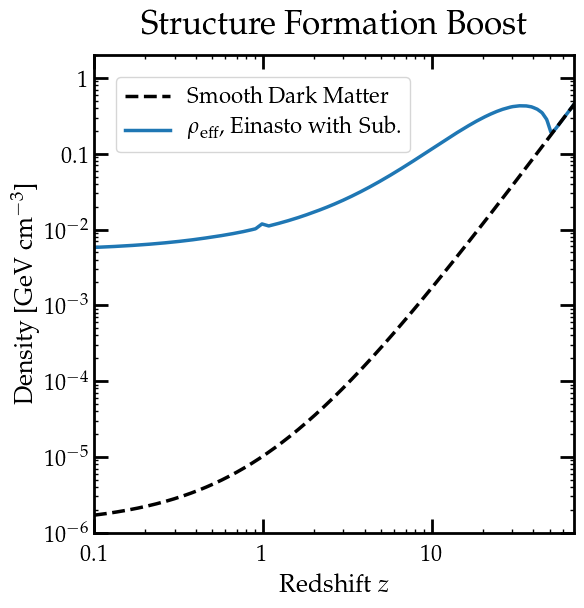

In [53]:
plt.figure()

plt.loglog()

z_vec = 10**np.arange(-1, 2, 0.005)
# Note that struct_boost accepts 1+z as the argument, which is the default
# way in which we pass redshift to functions in DarkHistory. 
rho_eff_vec = np.sqrt(struct_boost(1+z_vec)) * phys.rho_DM * (1+z_vec)**3 

# Convert to GeV/cm^3
rho_eff_vec /= 1e9

rho_eff_plot,    = plt.plot(z_vec, rho_eff_vec, label=r'$\rho_\mathrm{eff}$, Einasto with Sub.')
smooth_rho_plot, = plt.plot(z_vec, phys.rho_DM * (1+z_vec)**3 / 1e9, 'k--', label=r'Smooth Dark Matter')

plt.axis([0.1, 70, 1e-6, 2])
plt.xlabel('Redshift $z$')
plt.ylabel(r'Density [GeV cm$^{-3}$]')
plt.title('Structure Formation Boost')

plt.legend(handles=[smooth_rho_plot, rho_eff_plot])

## $\chi \chi \to b \bar{b}$ Annihilation

We are now ready to obtain the ionization and thermal history for a dark matter model with $m_\chi = $ 49 GeV, and a thermally-averaged annihilation cross section of $\langle \sigma v \rangle = 1.75 \times 10^{-26} \mathrm{ cm}^{-3} s^{-1}$. This model has been found to be consistent with the galactic center excess <cite data-cite="6232408/5QGGVCIF"></cite> and the 

In [11]:
withDM_noBR = main.evolve(
    DM_process='swave', mDM=49e9, sigmav=1.75e-26, primary='b',
    start_rs = 3000,
    coarsen_factor=32, backreaction=False,
    reion_switch=False,
    struct_boost=struct_boost
)


In [12]:
withDM_BR = main.evolve(
    DM_process='swave', mDM=49e9, sigmav=1.75e-26, primary='b',
    start_rs = 3000,
    coarsen_factor=32, backreaction=True,
    reion_switch=False,
    struct_boost=struct_boost
)

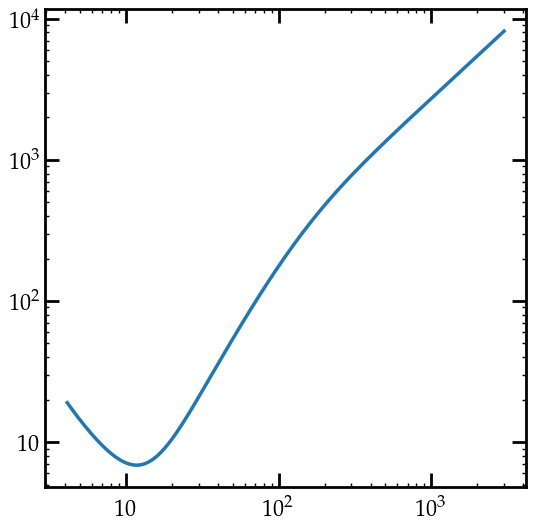

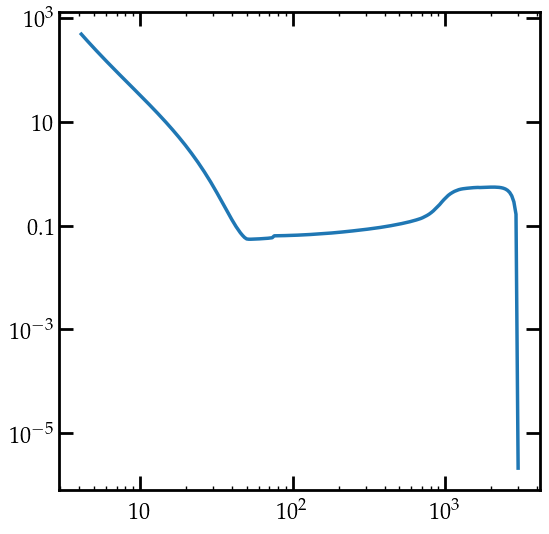

In [13]:
plt.figure()

rs_vec = withDM_noBR['highengphot'].rs

plt.loglog()

plt.plot(rs_vec, withDM_noBR['Tm']/phys.kB)

plt.figure()

rs_vec = withDM_noBR['highengphot'].rs

plt.loglog()

plt.plot(rs_vec, withDM_noBR['f']['low']['heat'])

In [ ]:
plt.figure(figsize=(15,6.5))

ax = plt.subplot(1,2,1)
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Matter Temperature $T_m$[K]')



In [ ]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature $T_{IGM}$[K]')

rs_list = withDM_noBR[3].rs[:-1]

plt.axis([5, 2e3, 1, 1e5])
# plt.axvline(5.8, color='gray', linestyle='--', alpha=0.3)

plot_noBR, = plt.plot(rs_list, withDM_noBR[1][:]/phys.kB, label='No Backreaction', color='C0')
plot_BR, = plt.plot(rs_list, withDM_BR[1][:]/phys.kB, label='With Backreaction', color='orange')
plot_CMB, = plt.plot(rs_list, phys.TCMB(rs_list)/phys.kB, label='CMB', color='k', linestyle='--')
plot_std, = plt.plot(rs_list, noDM[1][:]/phys.kB, label='No Dark Matter', color='C3')

legend = plt.legend(handles=[plot_noBR, plot_BR, plot_std, plot_CMB], loc=9,
           frameon=False, title='$\mathbf{\chi\chi \\rightarrow \overline{b}b}, m_\chi = 49$ GeV,'+
                    ' $\langle \sigma v \\rangle = 1.5 \\times 10^{-26}$ cm$^3$ s$^{-1}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/bb_bar_swave_T.png')

-The above is an example of what inputs need to be put in the code (back-reaction, structure formation, input spectra)

-Fix the normalization

In [ ]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Free Electron Fraction $x_e$')

plt.axis([5, 2e3, 1e-4, 5])
# plt.axvline(7, color='gray', linestyle='--', alpha=0.3)

plot_noBR, = plt.plot(rs_list, withDM_noBR[0][:,0], label='No Backreaction', color='C0')
plot_BR, = plt.plot(rs_list, withDM_BR[0][:,0], label='With Backreaction', color='orange')
plot_std, = plt.plot(rs_list, noDM[0][:,0], label='Standard', color='C3')

legend = plt.legend(handles=[plot_BR, plot_noBR, plot_std], loc=0, 
           frameon=False, title='$\mathbf{\chi\chi \\rightarrow \overline{b}b}, m_\chi = 49$ GeV,'+
                    ' $\langle \sigma v \\rangle = 1.5 \\times 10^{-26}$ cm$^3$ s$^{-1}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/bb_bar_swave_xe.png')

 Interpolations over the transfer function matrices for propagating photons (`highengphot_interp_tf`), low-energy photons (`lowengphot_interp_tf`), low-energy electrons (`lowengelec_interp_tf`), the energy of CMB photons upscattered per unit time (`CMB_engloss_interp`) and high-energy deposition (`highengdep_interp`). 

## Bibliography

<div class="cite2c-biblio"></div>